## Background 
This notebook showcases how to leverage Optuna for hyperparameter tuning, specifically for the n_lists and n_probes parameters. We will demonstrate how to optimize these parameters using Optuna's Bayesian optimization capabilities. 

Note: This notebook has been tested on Sagemaker Studio with an instance type of ml.g5.12xlarge.

In [ ]:
# Install Required Packages
%mamba install -c rapidsai-nightly -c conda-forge cuvs optuna -y
%pip install cupy

In [35]:
import cupy as cp
import numpy as np
from cuvs.neighbors import ivf_flat
import urllib.request
import time
import optuna
from utils import calc_recall
from optuna.visualization import plot_optimization_history
import math
import os

## Download wiki-all dataset


In [36]:
import tarfile

home_dir = os.path.expanduser("~/")


# wiki-all datasets are in tar format
def download_files(url, file):
    if os.path.exists(home_dir + "/" + file):
        print("tar file is already downloaded")
    else:
        urllib.request.urlretrieve(url, home_dir + "/" + file)
    # Open the .tar file
    with tarfile.open(home_dir + "/" + file, "r") as tar:
        filename = file.split(".")[0]
        if os.path.exists(home_dir + "/" + filename + "/"):
            print("Files already extracted")
            return home_dir + "/" + filename + "/"
        # Extract all contents into the specified directory
        extract_path = home_dir + "/" + file.split(".")[0]
        tar.extractall(extract_path)
    return extract_path

In [37]:
extracted_path = download_files(
    "https://data.rapids.ai/raft/datasets/wiki_all_1M/wiki_all_1M.tar",
    "wiki_all_1M.tar",
)

tar file is already downloaded
Files already extracted


## Dataset Preparation: Load fbin, ibin files 
This example utilizes the Wiki-1M dataset, a collection of four binary files containing: 

Database vectors: Used for index building and searching.
Query vectors: Used for index building and searching.
Ground truth neighbors: Associated with a particular distance, used for evaluation.
Distances: Associated with a particular distance, used for evaluation.
The file suffixes denote the data type of vectors stored in the file: 

.fbin: float32
.ibin: int
For more information on the Wiki-1M dataset, please refer to the [RAPIDS documentation](https://docs.rapids.ai/api/raft/nightly/ann_benchmarks_dataset)
.

In [38]:
def read_data(file_path, dtype):
    with open(file_path, "rb") as f:
        rows, cols = np.fromfile(f, count=2, dtype=np.int32)
        d = np.fromfile(f, count=rows * cols, dtype=dtype).reshape(rows, cols)
    return cp.asarray(d)

In [39]:
vectors = read_data(extracted_path + "/base.1M.fbin", np.float32)
queries = read_data(extracted_path + "/queries.fbin", np.float32)
gt_neighbors = read_data(
    extracted_path + "/groundtruth.1M.neighbors.ibin", np.int32
)

In [40]:
# Get the dataset size of database vectors
dataset_size = vectors.shape[0]
dim = vectors.shape[1]

## Visualization

Generates and displays Pareto front plots for a given Optuna study object.

In [83]:
def visualization(study_obj):
    """
    This function creates two Pareto front plots to visualize trade-offs between different
    optimization objectives. The plots help in understanding the balance between competing
    objectives in the optimization process.

    Args:
        study_obj (optuna.Study): The Optuna study object containing the optimization results.

    The function produces the following plots:
    1. **Figure 1**: A Pareto front plot showing the trade-off between `build_time_in_secs`
       and `recall`. It visualizes how the optimization process balances the build time
       and recall score.
    2. **Figure 2**: A Pareto front plot showing the trade-off between `latency_in_ms`
       and `recall`. This plot illustrates the relationship between latency and recall score.

    """

    fig1 = optuna.visualization.plot_pareto_front(
        study_obj,
        targets=lambda t: (t.values[0], t.values[2]),
        target_names=["build_time_in_secs", "recall"],
    )
    fig1.show()

    fig2 = optuna.visualization.plot_pareto_front(
        study_obj,
        targets=lambda t: (t.values[1], t.values[2]),
        target_names=["latency_in_ms", "recall"],
    )
    fig2.show()

In [98]:
def print_target_instance_summary(target_instance):
    print(f"\tnumber: {target_instance.number}")
    print(f"\tparams: {target_instance.params}")
    print(f"\tvalues: {target_instance.values}")


def print_best_trial_values(optuna_study):
    """
    Prints details about the trials on the Pareto front of an Optuna study.

    This function analyzes the best trials from an Optuna study, which are typically
    those with the most favorable trade-offs among multiple objectives. It prints
    information on three specific metrics:

    1. The number of trials on the Pareto front.
    2. The trial with the highest accuracy among the best trials.
    3. The trial with the lowest build time among the best trials.
    4. The trial with the lowest latency among the best trials.

    Parameters:
    optuna_study (optuna.study.Study): An Optuna study object that contains information
    about the trials and their respective metrics.

    The function assumes that each trial has three metrics recorded in the `values` list:
    - `values[0]`: Build time
    - `values[1]`: latency
    - `values[2]`: Accuracy

    """
    print(
        f"Number of trials on the Pareto front: {len(optuna_study.best_trials)}"
    )

    trial_with_lowest_build_time = min(
        optuna_study.best_trials, key=lambda t: t.values[0]
    )
    print("Trial with lowest build time in secs: ")
    print_target_instance_summary(trial_with_lowest_build_time)

    trial_with_lowest_latency = min(
        optuna_study.best_trials, key=lambda t: t.values[1]
    )
    print("Trial with lowest latency in ms: ")
    print_target_instance_summary(trial_with_lowest_latency)

    trial_with_highest_accuracy = max(
        optuna_study.best_trials, key=lambda t: t.values[2]
    )
    print("Trial with highest accuracy: ")
    print_target_instance_summary(trial_with_highest_accuracy)

## Hyperparameter Optimization (HPO) for CUVS Libraries

An Optuna trial object used to suggest values for the hyperparameters of various CUVS libraries (such as ivf_flat, ivf_pq, and cagra).

The multi-objective function returns a tuple of three float values, each rounded to four decimal places:

build_time_in_secs: Time taken to build the index, measured in seconds.
latency_in_ms: Average search latency, measured in milliseconds. Calculated as the total search time divided by the number of queries.
recall: Recall metric, indicating the proportion of relevant neighbors retrieved.


## ivf_flat HPO example

In [86]:
def multi_objective_ivf_flat(trial):
    """
    Optimizes the parameters for an Inverted File Index (IVF) Flat index in a multi-objective setting.

    """
    # Suggest an integer for the number of lists
    n_lists = trial.suggest_int("n_lists", 10, dataset_size * 0.1)
    # Suggest an integer for the number of probes
    n_probes = trial.suggest_int("n_probes", n_lists * 0.01, n_lists * 0.1)
    build_params = ivf_flat.IndexParams(
        n_lists=n_lists,
    )
    start_build_time = time.time()
    index = ivf_flat.build(build_params, vectors)
    build_time_in_secs = time.time() - start_build_time

    # Configure search parameters
    search_params = ivf_flat.SearchParams(n_probes=n_probes)
    # Perform the search
    start_search_time = time.time()
    distances, indices = ivf_flat.search(search_params, index, queries, k=10)
    search_time = time.time() - start_search_time

    latency_in_ms = (search_time * 1000) / queries.shape[0]

    found_distances, found_indices = cp.asnumpy(distances), cp.asnumpy(indices)
    recall = calc_recall(found_indices, gt_neighbors)
    return (
        round(build_time_in_secs, 4),
        round(latency_in_ms, 4),
        round(recall, 4),
    )

In [45]:
ivf_flat_study = optuna.create_study(
    directions=["minimize", "minimize", "maximize"]
)
ivf_flat_study.optimize(multi_objective_ivf_flat, n_trials=10)

[I 2024-08-19 16:24:19,149] A new study created in memory with name: no-name-ab0e88bd-1516-4eb2-a60d-01ae30ad08c4
[I 2024-08-19 16:24:51,762] Trial 0 finished with values: [23.1406, 0.3441, 0.9994] and parameters: {'n_lists': 48570, 'n_probes': 2511}. 
[I 2024-08-19 16:25:28,379] Trial 1 finished with values: [24.232, 0.6336, 0.9999] and parameters: {'n_lists': 51021, 'n_probes': 4945}. 
[I 2024-08-19 16:25:58,230] Trial 2 finished with values: [22.675, 0.1172, 0.9949] and parameters: {'n_lists': 47692, 'n_probes': 760}. 
[I 2024-08-19 16:26:54,339] Trial 3 finished with values: [42.3469, 0.7272, 0.9997] and parameters: {'n_lists': 91882, 'n_probes': 6687}. 
[I 2024-08-19 16:27:29,832] Trial 4 finished with values: [27.2722, 0.2141, 0.9985] and parameters: {'n_lists': 57879, 'n_probes': 1657}. 
[I 2024-08-19 16:28:22,050] Trial 5 finished with values: [42.7912, 0.2936, 0.999] and parameters: {'n_lists': 92899, 'n_probes': 2804}. 
[I 2024-08-19 16:28:54,048] Trial 6 finished with values

In [99]:
print_best_trial_values(ivf_flat_study)

Number of trials on the Pareto front: 8
Trial with lowest build time in secs: 
	number: 9
	params: {'n_lists': 35266, 'n_probes': 3028}
	values: [17.2627, 0.5324, 0.9998]
Trial with lowest latency in ms: 
	number: 6
	params: {'n_lists': 52962, 'n_probes': 668}
	values: [24.9842, 0.0949, 0.9935]
Trial with highest accuracy: 
	number: 1
	params: {'n_lists': 51021, 'n_probes': 4945}
	values: [24.232, 0.6336, 0.9999]


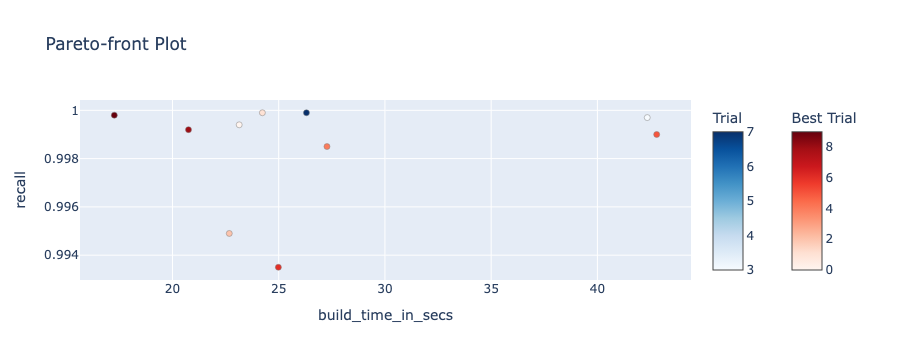

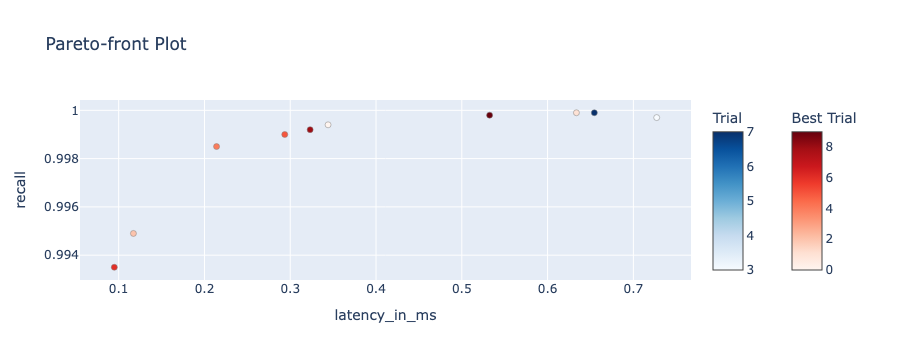

In [47]:
visualization(ivf_flat_study)

## ivf_pq HPO example

In [65]:
from cuvs.neighbors import ivf_pq, refine

In [87]:
def multi_objective_ivf_pq(trial):
    """
    Optimizes hyperparameters for Inverted File Product Quantization (IVF-PQ) in a multi-objective setting..

    """
    # Suggest values for build parameters
    pq_dim = trial.suggest_int("pq_dim", dim * 0.25, dim, step=2)
    n_lists = 1000

    # Suggest an integer for the number of probes
    n_probes = trial.suggest_int("n_probes", n_lists * 0.01, n_lists * 0.1)

    build_params = ivf_pq.IndexParams(
        n_lists=n_lists,
        pq_dim=pq_dim,
    )

    start_build_time = time.time()
    index = ivf_pq.build(build_params, vectors)
    build_time_in_secs = time.time() - start_build_time

    # Configure search parameters
    search_params = ivf_pq.SearchParams(n_probes=n_probes)

    # perform search and refine to increase recall/accuracy
    start_search_time = time.time()
    distances, indices = ivf_pq.search(search_params, index, queries, k=10)
    search_time = time.time() - start_search_time

    latency_in_ms = (search_time * 1000) / queries.shape[0]

    found_distances, found_indices = cp.asnumpy(distances), cp.asnumpy(indices)
    recall = calc_recall(found_indices, gt_neighbors)

    return (
        round(build_time_in_secs, 4),
        round(latency_in_ms, 4),
        round(recall, 4),
    )

In [67]:
ivf_pq_study = optuna.create_study(
    directions=["minimize", "minimize", "maximize"]
)
ivf_pq_study.optimize(multi_objective_ivf_pq, n_trials=10)

[I 2024-08-19 16:41:17,476] A new study created in memory with name: no-name-f823ce34-eccc-4c5a-a90d-1963f50a3a89


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 662


[I 2024-08-19 16:41:39,686] Trial 0 finished with values: [9.7626, 0.6995, 0.9562] and parameters: {'pq_dim': 662, 'n_probes': 79}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 210


[I 2024-08-19 16:41:51,544] Trial 1 finished with values: [4.9705, 0.1443, 0.8414] and parameters: {'pq_dim': 210, 'n_probes': 57}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 678


[I 2024-08-19 16:42:15,891] Trial 2 finished with values: [10.0147, 0.8856, 0.9581] and parameters: {'pq_dim': 678, 'n_probes': 98}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 432


[I 2024-08-19 16:42:34,553] Trial 3 finished with values: [9.3991, 0.3831, 0.9497] and parameters: {'pq_dim': 432, 'n_probes': 70}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 410


[I 2024-08-19 16:42:52,606] Trial 4 finished with values: [9.018, 0.3598, 0.9471] and parameters: {'pq_dim': 410, 'n_probes': 69}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 242


[I 2024-08-19 16:43:04,224] Trial 5 finished with values: [4.2757, 0.1919, 0.8495] and parameters: {'pq_dim': 242, 'n_probes': 66}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 688


[I 2024-08-19 16:43:24,543] Trial 6 finished with values: [10.1002, 0.4773, 0.9518] and parameters: {'pq_dim': 688, 'n_probes': 50}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 388


[I 2024-08-19 16:43:42,703] Trial 7 finished with values: [8.6237, 0.411, 0.9475] and parameters: {'pq_dim': 388, 'n_probes': 85}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 286


[I 2024-08-19 16:43:57,057] Trial 8 finished with values: [6.0929, 0.2856, 0.8991] and parameters: {'pq_dim': 286, 'n_probes': 79}. 


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 284


[I 2024-08-19 16:44:09,228] Trial 9 finished with values: [6.0429, 0.0726, 0.8775] and parameters: {'pq_dim': 284, 'n_probes': 19}. 


In [100]:
print_best_trial_values(ivf_pq_study)

Number of trials on the Pareto front: 10
Trial with lowest build time in secs: 
	number: 5
	params: {'pq_dim': 242, 'n_probes': 66}
	values: [4.2757, 0.1919, 0.8495]
Trial with lowest latency in ms: 
	number: 9
	params: {'pq_dim': 284, 'n_probes': 19}
	values: [6.0429, 0.0726, 0.8775]
Trial with highest accuracy: 
	number: 2
	params: {'pq_dim': 678, 'n_probes': 98}
	values: [10.0147, 0.8856, 0.9581]


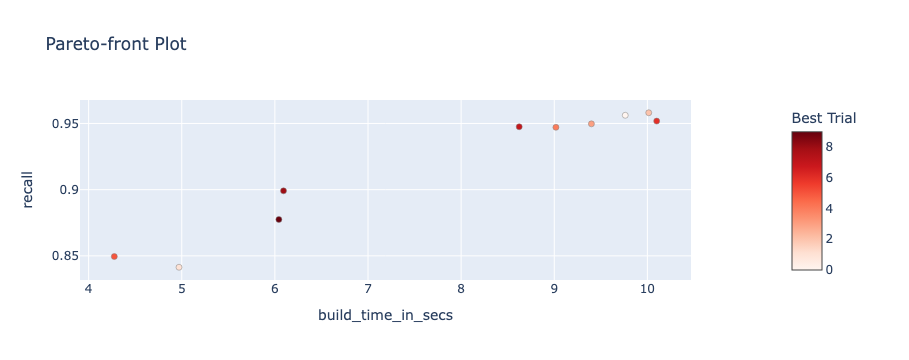

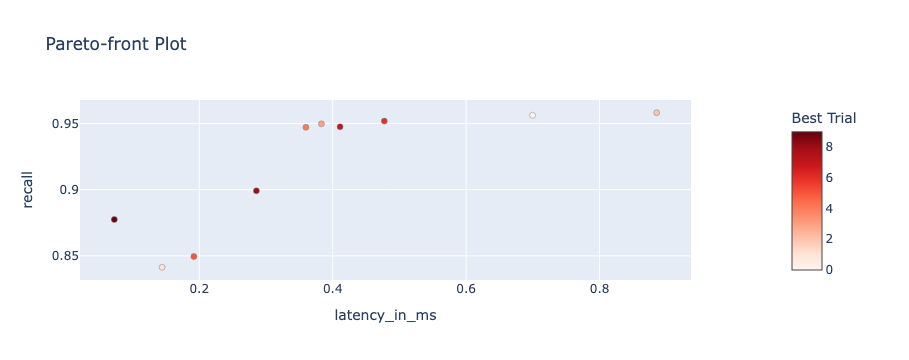

In [68]:
visualization(ivf_pq_study)

## cagra HPO example

In [72]:
from cuvs.neighbors import cagra

In [89]:
def multi_objective_cagra(trial):
    """
    Optimizes the parameters for the cagra index using a multi-objective approach.

    """
    # Suggest values for build parameters
    intermediate_graph_degree = trial.suggest_int(
        "intermediate_graph_degree", 64, 128, step=2
    )

    # Suggest an integer for the number of probes
    itopk_size = trial.suggest_int("itopk_size", 64, 128, step=2)

    build_params = cagra.IndexParams(
        intermediate_graph_degree=intermediate_graph_degree
    )

    start_build_time = time.time()
    cagra_index = cagra.build(build_params, vectors)
    build_time_in_secs = time.time() - start_build_time

    # Configure search parameters
    search_params = cagra.SearchParams(itopk_size=itopk_size)

    # perform search and refine to increase recall/accuracy
    start_search_time = time.time()
    distances, indices = cagra.search(
        search_params, cagra_index, queries, k=10
    )
    search_time = time.time() - start_search_time

    latency_in_ms = (search_time * 1000) / queries.shape[0]

    found_distances, found_indices = cp.asnumpy(distances), cp.asnumpy(indices)
    recall = calc_recall(found_indices, gt_neighbors)

    return (
        round(build_time_in_secs, 4),
        round(latency_in_ms, 4),
        round(recall, 4),
    )

In [74]:
cagra_study = optuna.create_study(
    directions=["minimize", "minimize", "maximize"]
)
cagra_study.optimize(multi_objective_cagra, n_trials=5)

[I 2024-08-19 16:53:39,324] A new study created in memory with name: no-name-b457b87f-2a54-4e19-944d-5902bf10ea8e


using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 192


[I 2024-08-19 16:56:22,063] Trial 0 finished with values: [157.0238, 0.0412, 0.9903] and parameters: {'intermediate_graph_degree': 76, 'itopk_size': 124}. 


[I] [16:56:15.120128] optimizing graph
[I] [16:56:16.300838] Graph optimized, creating index
using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 192


[I 2024-08-19 16:59:03,390] Trial 1 finished with values: [155.633, 0.0364, 0.9884] and parameters: {'intermediate_graph_degree': 72, 'itopk_size': 106}. 


[I] [16:58:56.534874] optimizing graph
[I] [16:58:57.649931] Graph optimized, creating index
using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 192


[I 2024-08-19 17:01:51,648] Trial 2 finished with values: [162.741, 0.0231, 0.9801] and parameters: {'intermediate_graph_degree': 90, 'itopk_size': 66}. 


[I] [17:01:44.581010] optimizing graph
[I] [17:01:46.084702] Graph optimized, creating index
using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 192


[I 2024-08-19 17:04:46,930] Trial 3 finished with values: [169.5533, 0.0396, 0.9915] and parameters: {'intermediate_graph_degree': 110, 'itopk_size': 114}. 


[I] [17:04:39.128583] optimizing graph
[I] [17:04:41.155907] Graph optimized, creating index
using ivf_pq::index_params nrows 1000000, dim 768, n_lits 1000, pq_dim 192


[I 2024-08-19 17:07:31,215] Trial 4 finished with values: [158.4761, 0.0414, 0.9905] and parameters: {'intermediate_graph_degree': 80, 'itopk_size': 126}. 


In [101]:
print_best_trial_values(cagra_study)

Number of trials on the Pareto front: 5
Trial with lowest build time in secs: 
	number: 1
	params: {'intermediate_graph_degree': 72, 'itopk_size': 106}
	values: [155.633, 0.0364, 0.9884]
Trial with lowest latency in ms: 
	number: 2
	params: {'intermediate_graph_degree': 90, 'itopk_size': 66}
	values: [162.741, 0.0231, 0.9801]
Trial with highest accuracy: 
	number: 3
	params: {'intermediate_graph_degree': 110, 'itopk_size': 114}
	values: [169.5533, 0.0396, 0.9915]


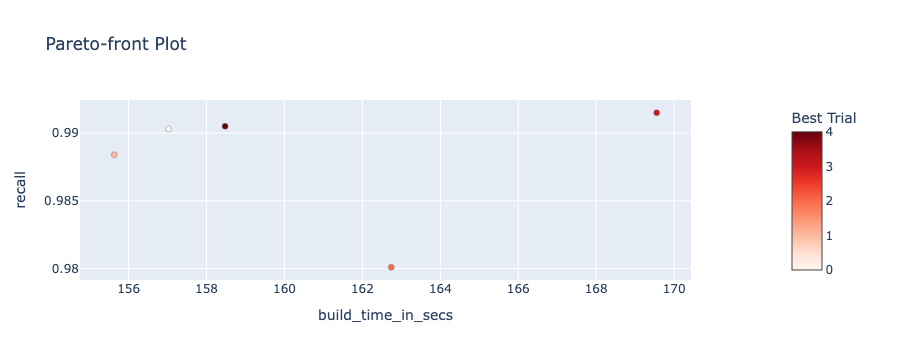

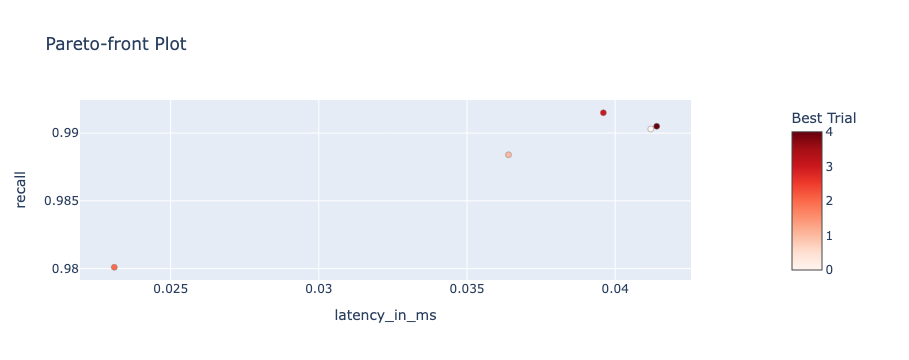

In [82]:
visualization(cagra_study)